<a href="https://colab.research.google.com/github/idan424/Comp.Learning_Neuro/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Introduction

An experiment for muscle contributions to movement was conducted, and marker position data was acquired from 42 different markers.

originally the experimental analysis was preformed using a custom simulation.

This approach was created to analise EMG data \w respect to position.

Our goal is to use marker position data to forecast the subjects' running speed, which is a different goal than the one the paper has taken

We show different aproaches to a multiclass classification problem and discuss the diffrence between the methods.

finally, we present 5 combinations of feature selection + model, and their results.

---

# Previous work

**Study - Hamner SR and Delp SL. Muscle contributions to foreaft and vertical body mass center accelerations over a range of running speeds:**

The goal of this study was to determine how muscles and arm swing affect dynamics of the body at different running speeds.

They determined how muscles contribute to mass center accelerations during the stance phase of running, and how the arms act to counterbalance the motion of the legs.

They achieved this goal by creating and analyzing muscle-driven, forward dynamic simulations of 10 subjects running across a range of speeds.

An induced acceleration analysis determined the contribution of each muscle to mass center accelerations.

The simulations also included arm motion, allowing to investigate the contributions of arm swing to running dynamics.

---

# Preprocessing 

>## Imports & setup

In [ ]:
import warnings
warnings.simplefilter("ignore")
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split


In [ ]:
!git clone https://github.com/idan424/Comp.Learning_Neuro

Cloning into 'Comp.Learning_Neuro'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 10), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
PATH = '/content/Comp.Learning_Neuro/'
_files = ['Run_200 02.trc', 'Run_300 02.trc', 
          'Run_400 02.trc', 'Run_500 02.trc']
f = _files[0]

>## Data augmentation

In [ ]:
def load_data(f):
    _data = pd.read_table(PATH+f, header=4, index_col=0).iloc[:,:-1]
    _data = _data.rename(columns={'Unnamed: 1':'Time'})
    _data.reset_index(inplace=True)
    labels = pd.DataFrame(np.ones(len(_data)-2)*int(f[4:7]))
    
    return _data, labels
    
 
def add_norm(_data):
    for n in range(1,len(_data.columns)//3+1):
        R_data = np.linalg.norm(_data[[f"X{n}",f"Y{n}",f"Z{n}"]].values,axis=1)
        _data.insert(n*4+1,f'norm{n}',R_data)
    
    return _data
    
 
def add_av(_data):
    v_data = _data.copy().drop(['Time','index'], axis=1).diff()
    a_data = v_data.diff()
 
    v_data = v_data.rename(columns={n:f"V_{n}" for n in _data.columns})
    a_data = a_data.rename(columns={n:f"A_{n}" for n in _data.columns})
 
    return _data.join([v_data, a_data]).dropna()
 
 
def divide_dataset(_data, label):
    N = len(_data)//10
    
    return [ _data.loc[10*n:10*(n+1)-1] for n in range(N)], label[0:N]

>## Feature generation

Each sample showen by X,Y,Z coordinates for every marker. we split the samples to segments of 10 samples each and genrate the following fetures for every segment: 


X/Y/Z min - minimum value of every coordinate at the segment.

X/Y/Z max - maximum value of every coordinate at the segment.

X/Y/Z std - standard deviation of every coordinate at the segment.

X/Y/Z mean - mean value of every coordinate at the segment.

X/Y/Z median - median of every coordinate at the segment.


We also extract velocity and accelaration of each coordinate and generate the same features for those.


And also extract the magnitude of the location/velocity/accelration vector and generate the same features for it.

***A code walkthrough will make everything clearer.***

In [ ]:
def segment_processing(_seg): 
    seg = _seg.drop(['Time','index'], axis=1)
 
    mean_data = seg.mean().rename({n:f'mean_{n}'for n in seg.columns})
    std_data = seg.std().rename({n:f'std_{n}'for n in seg.columns})
    max_data = seg.max().rename({n:f'max_{n}'for n in seg.columns})
    min_data = seg.min().rename({n:f'min_{n}'for n in seg.columns})
    median_data = seg.median().rename({n:f'median_{n}'for n in seg.columns})
 
    return mean_data.append([std_data,max_data,min_data,median_data])  # returns a pd.Series()

 
def extract_features(seg_list):
    data = pd.DataFrame([segment_processing(seg) for seg in seg_list]) 

    return data

>## Preprocessing touch-ups

In [ ]:
def process_file(f):
    X,y = load_data(f)
    X = add_norm(X)
    X = add_av(X)
    
    segments, y = divide_dataset(X, y)
    X = extract_features(segments)
 
    return (X,y)  # returns a tuple

In [ ]:
files = _files
Xy = [process_file(f) for f in files]
Xy = list(zip(*Xy))  # this flip the tuple axis order
 
X, y = pd.concat(Xy[0]), pd.concat(Xy[1])
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

>## Data presentation - pre feature selection


In [ ]:
#@title X table
X.head(10)

,mean_X1,mean_Y1,mean_Z1,mean_norm1,mean_X2,mean_Y2,mean_Z2,mean_norm2,mean_X3,mean_Y3,mean_Z3,mean_norm3,mean_X4,mean_Y4,mean_Z4,mean_norm4,mean_X5,mean_Y5,mean_Z5,mean_norm5,mean_X6,mean_Y6,mean_Z6,mean_norm6,mean_X7,mean_Y7,mean_Z7,mean_norm7,mean_X8,mean_Y8,mean_Z8,mean_norm8,mean_X9,mean_Y9,mean_Z9,mean_norm9,mean_X10,mean_Y10,mean_Z10,mean_norm10,...,median_A_X33,median_A_Y33,median_A_Z33,median_A_norm33,median_A_X34,median_A_Y34,median_A_Z34,median_A_norm34,median_A_X35,median_A_Y35,median_A_Z35,median_A_norm35,median_A_X36,median_A_Y36,median_A_Z36,median_A_norm36,median_A_X37,median_A_Y37,median_A_Z37,median_A_norm37,median_A_X38,median_A_Y38,median_A_Z38,median_A_norm38,median_A_X39,median_A_Y39,median_A_Z39,median_A_norm39,median_A_X40,median_A_Y40,median_A_Z40,median_A_norm40,median_A_X41,median_A_Y41,median_A_Z41,median_A_norm41,median_A_X42,median_A_Y42,median_A_Z42,median_A_norm42
0,1082.295521,1095.245126,-232.696401,1557.265861,944.188225,1147.877247,-427.606724,1546.598024,929.325773,1144.952988,-315.217140,1507.956028,1018.758629,821.411510,-208.034740,1325.093640,1104.119685,691.055169,-212.155103,1319.717819,1040.472288,950.449616,-530.904356,1505.924032,930.642935,816.854386,-492.805284,1332.750533,954.946531,675.325266,-479.611568,1264.138295,1199.702350,447.928527,-274.682285,1309.724685,1118.422386,400.209070,-210.889443,1206.492303,...,0.866275,-1.236516,0.170650,-0.397853,-0.571089,-1.272532,0.079562,-1.264720,-0.008088,-1.580289,0.004025,-1.082080,-0.487208,-1.776385,-0.108528,-1.504472,-3.873763,-0.312937,0.290286,-3.869722,0.050140,-0.917250,-0.144125,-0.650739,-0.247517,-1.016520,0.248317,-0.823220,-2.336469,0.370954,0.015978,-2.095193,0.391377,-1.394880,0.364609,-1.004319,-0.184623,-0.946824,0.020367,-0.778810
1,1084.604082,1064.520578,-227.448582,1536.705491,940.529421,1112.958376,-422.530860,1517.215896,928.706213,1110.168758,-310.234848,1480.324394,1012.969729,788.577929,-203.405626,1299.818309,1099.292639,654.791056,-210.309233,1296.797337,1052.102649,917.486754,-522.147930,1490.504640,960.374263,772.818000,-487.508390,1325.896064,1003.110783,635.663851,-475.449048,1279.555928,1192.722848,413.195688,-282.292181,1293.556849,1114.212961,364.752778,-215.714290,1192.117114,...,0.688285,-1.316724,0.164297,-0.529122,-0.488520,-1.220371,-0.020941,-1.113109,-0.348537,-1.711650,-0.193660,-1.403666,-0.456338,-1.603777,-0.475096,-1.256071,-2.171633,-0.502267,0.122890,-1.933153,-0.291760,-0.692863,0.093909,-0.440801,-0.242651,-0.949052,0.163863,-0.861534,-1.436698,-0.609837,0.180715,-1.538439,0.486597,-1.394998,0.396620,-0.923129,-0.181617,-0.749023,-0.093186,-0.483643
2,1070.161569,1020.873275,-222.591128,1495.658070,917.742318,1066.938881,-417.106982,1467.863658,910.540552,1065.911800,-304.994036,1434.677476,992.714429,748.948376,-203.749267,1260.168800,1076.964168,611.022829,-211.909323,1256.268004,1046.145985,877.850802,-519.703582,1461.218997,1003.122322,719.413104,-483.364512,1325.714092,1083.991874,600.485220,-480.985176,1329.310151,1121.633834,363.811999,-296.119172,1215.855850,1037.018680,339.237104,-222.049062,1113.546363,...,0.931046,2.968539,-0.744063,2.357244,-0.254319,2.205152,-0.137364,1.335893,-0.735735,2.893951,-0.352230,1.492504,-0.666927,2.661176,-0.170968,1.304217,-0.050731,0.098378,-0.036806,0.002235,-0.189694,0.820140,-0.140798,0.376131,-0.626162,1.777239,-0.175784,1.185285,-0.604126,0.475082,0.261831,-0.474892,0.021749,2.051480,-0.326141,1.574530,0.442409,1.012899,0.114094,0.818633
3,1064.539822,1058.189897,-224.682880,1517.779298,907.645136,1112.830831,-413.339640,1494.418079,904.299931,1108.473829,-300.835418,1461.891459,927.015815,788.412731,-206.147524,1234.556882,966.576084,635.127683,-220.404151,1177.821527,1038.329368,929.307882,-528.470510,1490.430844,1027.382430,767.687079,-491.864182,1373.731922,1131.305103,666.717732,-483.514370,1399.496954,959.693573,378.686254,-301.013690,1075.214810,872.998207,363.799768,-229.155849,973.771428,...,-1.225258,0.050835,0.212688,-1.00416

In [ ]:
#@title X's stats
X.describe()

,mean_X1,mean_Y1,mean_Z1,mean_norm1,mean_X2,mean_Y2,mean_Z2,mean_norm2,mean_X3,mean_Y3,mean_Z3,mean_norm3,mean_X4,mean_Y4,mean_Z4,mean_norm4,mean_X5,mean_Y5,mean_Z5,mean_norm5,mean_X6,mean_Y6,mean_Z6,mean_norm6,mean_X7,mean_Y7,mean_Z7,mean_norm7,mean_X8,mean_Y8,mean_Z8,mean_norm8,mean_X9,mean_Y9,mean_Z9,mean_norm9,mean_X10,mean_Y10,mean_Z10,mean_norm10,...,median_A_X33,median_A_Y33,median_A_Z33,median_A_norm33,median_A_X34,median_A_Y34,median_A_Z34,median_A_norm34,median_A_X35,median_A_Y35,median_A_Z35,median_A_norm35,median_A_X36,median_A_Y36,median_A_Z36,median_A_norm36,median_A_X37,median_A_Y37,median_A_Z37,median_A_norm37,median_A_X38,median_A_Y38,median_A_Z38,median_A_norm38,median_A_X39,median_A_Y39,median_A_Z39,median_A_norm39,median_A_X40,median_A_Y40,median_A_Z40,median_A_norm40,median_A_X41,median_A_Y41,median_A_Z41,median_A_norm41,median_A_X42,median_A_Y42,median_A_Z42,median_A_norm42
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,...,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,965.030719,1063.527321,-276.150036,1467.484399,849.150597,1105.953021,-359.693536,1441.246563,876.099261,985.371708,-248.349969,1347.332709,921.945090,787.047997,-197.377824,1232.350445,944.376615,753.700436,-291.388682,1254.621701,943.894411,812.687618,-437.576672,1328.178513,937.321616,776.237162,-493.548682,1316.890684,947.880167,623.249334,-428.045003,1221.532943,931.964195,483.848695,-312.694034,1106.397629,919.332087,431.783327,-281.988477,1062.250776,...,0.009385,-0.077234,-0.033975,-0.058753,0.002925,-0.152621,-0.002826,-0.137156,-0.040290,-0.202060,-0.008231,-0.136480,-0.031732,-0.101570,0.031497,-0.094271,0.000753,-0.137131,-0.020611,-0.097305,0.006344,-0.161499,0.002561,-0.121436,0.004126,-0.023878,-0.002246,-0.037623,-0.033208,-0.141143,0.016380,-0.104924,-0.012658,-0.154930,-0.026380,-0.092592,0.028478,0.004191,0.003359,0.000742
std,85.872256,38.961349,84.558660,34.130595,32.513609,28.382825,57.017335,39.163367,53.910167,143.013938,55.612880,106.858195,72.040614,106.497114,19.350204,83.462318,87.367307,118.026767,144.302897,115.746231,74.347513,115.565283,136.133762,128.271616,73.390658,102.181229,20.110230,84.460160,130.844800,130.158116,87.530664,142.503323,169.748119,109.416603,97.884469,165.826259,173.411013,54.331869,86.170016,155.078171,...,0.782452,1.656731,0.434858,1.224221,0.835786,1.691091,0.411209,1.219614,0.884728,1.847598,0.477646,1.369147,0.912039,1.614526,0.531117,1.322810,1.610653,1.503840,0.449478,1.669750,1.395824,1.583854,0.450671,1.499900,0.629769,1.314644,0.333340,0.991690,1.013354,1.688678,0.455066,1.387225,0.827922,1.627924,0.347640,1.239141,0.354457,0.863990,0.213106,0.723496
min,777.622640,983.454244,-439.643621,1391.372495,774.886576,1052.632535,-436.142011,1353.231457,755.239717,733.688291,-323.863891,1116.296856,724.940223,586.652703,-240.115352,1026.778309,740.239860,576.462463,-551.825894,1021.552602,750.161617,595.587344,-547.863438,1054.011637,749.491209,590.345033,-541.213517,1110.125497,604.650587,348.387882,-512.876647,818.242494,519.608702,331.791148,-498.800282,746.297061,520.386936,335.552992,-448.413214,742.561427,...,-1.684723,-2.765874,-1.377224,-2.324490,-1.752742,-2.882693,-1.393024,-2.821403,-2.494154,

In [ ]:
#@title X's info
X.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 2520 columns):
 #    Column           Non-Null Count  Dtype  
---   ------           --------------  -----  
 0    mean_X1          190 non-null    float64
 1    mean_Y1          190 non-null    float64
 2    mean_Z1          190 non-null    float64
 3    mean_norm1       190 non-null    float64
 4    mean_X2          190 non-null    float64
 5    mean_Y2          190 non-null    float64
 6    mean_Z2          190 non-null    float64
 7    mean_norm2       190 non-null    float64
 8    mean_X3          190 non-null    float64
 9    mean_Y3          190 non-null    float64
 10   mean_Z3          190 non-null    float64
 11   mean_norm3       190 non-null    float64
 12   mean_X4          190 non-null    float64
 13   mean_Y4          190 non-null    float64
 14   mean_Z4          190 non-null    float64
 15   mean_norm4       190 non-null    float64
 16   mean_X5          190 non-null    float64


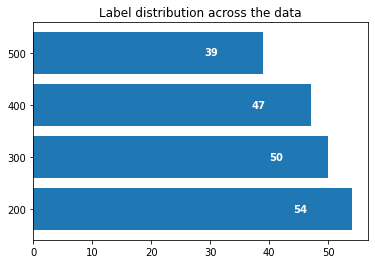

In [ ]:
#@title Train Test Split
fig, ax = plt.subplots()  

_ = ax.barh(range(4), y.value_counts().ravel(), 
            tick_label=[200,300,400,500])
_ = ax.set_title(f"Label distribution across the data")

for i, v in enumerate(y.value_counts().ravel()):
    ax.text(v-10, i-0.05, f'{v}', color='white', fontweight='bold')

---

# Data Processing

In [ ]:
#@title Train Test Split (80% Train,20% Test)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

>## Normalization and Select K-Best features by Mutual Information(MI)

In order to avoid leakage, we fit our transforms (norm, feat. select.) on the training data, and then transform the data (both train and test)

In [ ]:
from sklearn.feature_selection import mutual_info_classif as MI
from sklearn.feature_selection import SelectKBest as SKB 
from sklearn.preprocessing import MinMaxScaler as NRM
 
NUMBER_OF_FEATURES = int(X_train.shape[0]**0.5)
 
nrm = NRM().fit(X_train.values) # normalization function
skb = SKB(score_func=MI, k=NUMBER_OF_FEATURES).fit(X_train, y_train) # feature selector utility
 
# X_train and X_test are both normalized with respect to X_train to prevent leakage
X_train = pd.DataFrame(nrm.transform(X_train.values), columns=X_train.columns)
X_test = pd.DataFrame(nrm.transform(X_test.values), columns=X_test.columns)
 
# These are the best-K feature matrices (np.array type)
X_train_skb = skb.transform(X_train)  
X_test_skb = skb.transform(X_test)

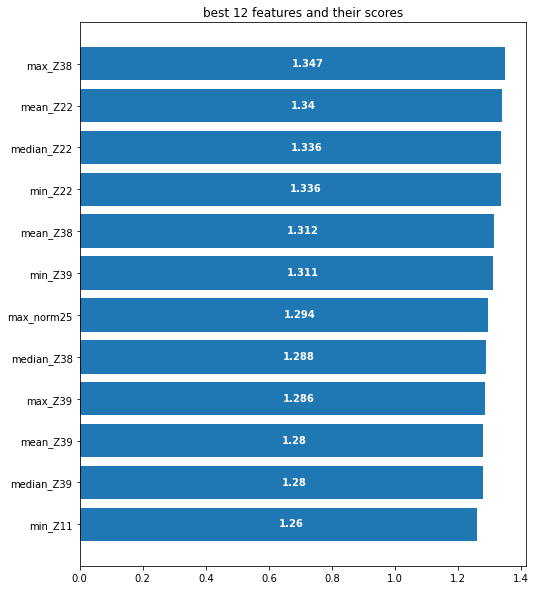

In [ ]:
#@title Best K=12 features' MI score
N_PRINT = NUMBER_OF_FEATURES
# this gets $N_PRINT score indices from high to low
ord_idx = skb.scores_.argsort()[-N_PRINT-1:-1]
 
fig, ax = plt.subplots()  
fig.set_size_inches([8,N_PRINT/3+6]) # modular figure size w.r.t. $N_PRINT
 
# these just prettify the graph
_ = ax.barh(range(N_PRINT), skb.scores_[ord_idx], 
            tick_label=X_train.columns[ord_idx])
_ = ax.set_title(f"best {N_PRINT} features and their scores")
for i, v in enumerate(skb.scores_[ord_idx]):
    ax.text(v/2, i-0.05, f'{v:.4}', color='white', fontweight='bold')


>## PCA

We used PCA for dimentionality reduction, which also selected features for us, giving us a denser representation of the relevant data.

The number of principle components we selected was 12, like K from SKB feature selection method.


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=NUMBER_OF_FEATURES)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


evr = pca.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)

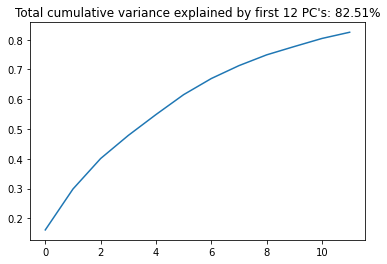

In [ ]:
#@title Cumulative variance explained by 12 first PCs
_ = plt.plot(cumulative_evr)
_ = plt.title(f"Total cumulative variance explained by first {NUMBER_OF_FEATURES} PC's: {cumulative_evr[-1]*100:.2f}%")

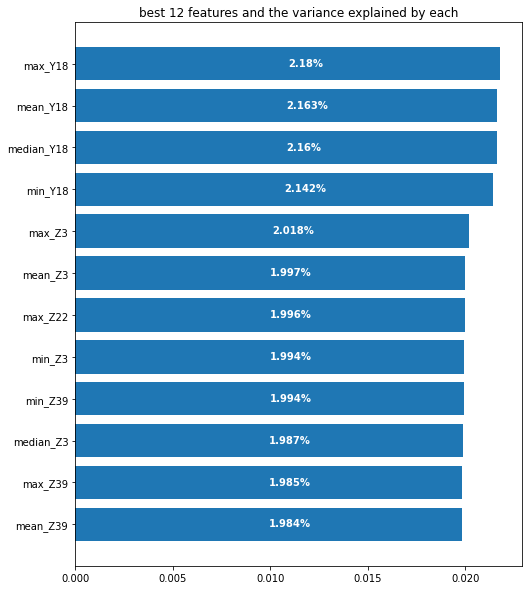

In [ ]:
#@title Total variance explained by best 12 original features
# for every original feature we calculate the weighted (by var explained PC) sum of variance which is explained by it
var_per_orig_feature = evr.dot(pca.components_)
# then we take the 12 most "succesfull" features
pca_best_idx = var_per_orig_feature.argsort()[-NUMBER_OF_FEATURES:][::-1]
pca_best_scores = var_per_orig_feature[pca_best_idx][::-1]
pca_best_names = X.columns[pca_best_idx][::-1]


fig, ax = plt.subplots()  
fig.set_size_inches([8,N_PRINT/3+6]) # modular figure size w.r.t. $N_PRINT
 
# these just prettify the grap
_ = ax.barh(range(N_PRINT), pca_best_scores, tick_label=pca_best_names)

_ = ax.set_title(f"best {N_PRINT} features and the variance explained by each")
for i, v in enumerate(pca_best_scores):
    ax.text(v/2, i-0.05, f'{v*100:.4}%', color='white', fontweight='bold')



---

# EDA

>## Select K-Best

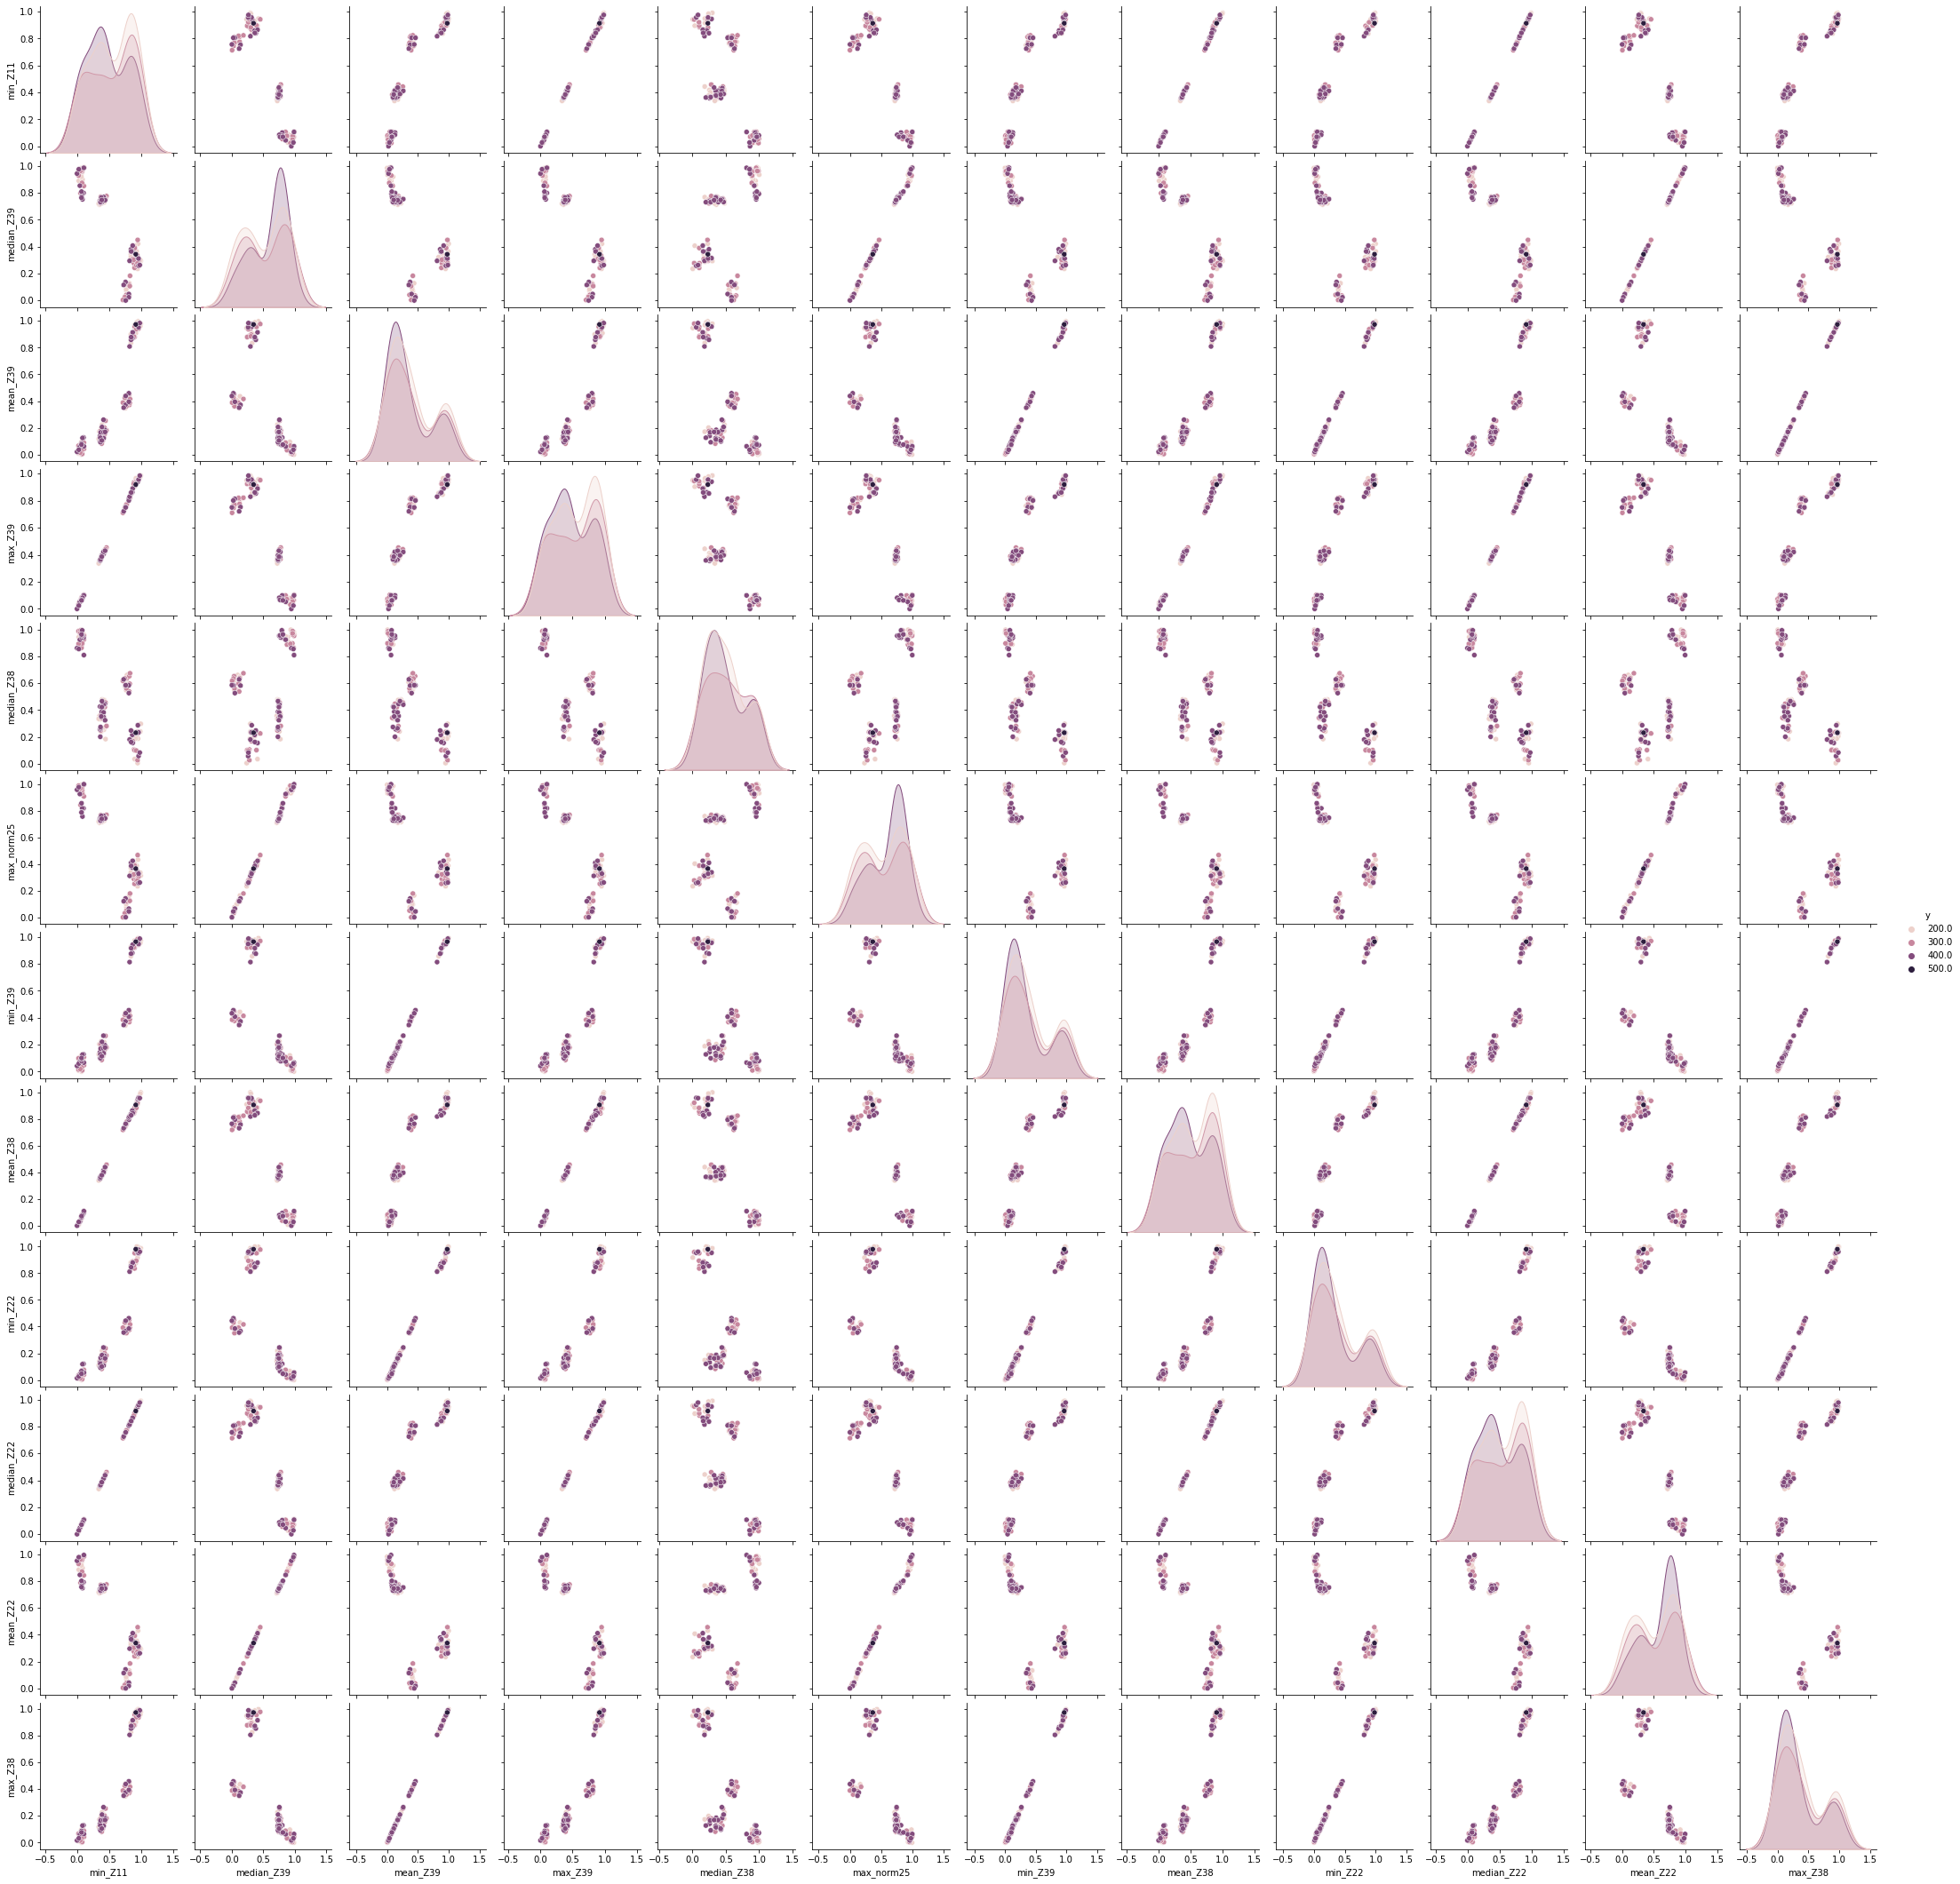

In [ ]:
#@title Select K-best Pairs Plot

# this takes a few minutes to calculate - avoid if possible
X_skb = pd.DataFrame(data=X_train_skb, columns=X_train.columns[ord_idx])
X_skb['y'] = y_train
_ = sns.pairplot(X_skb, hue='y')


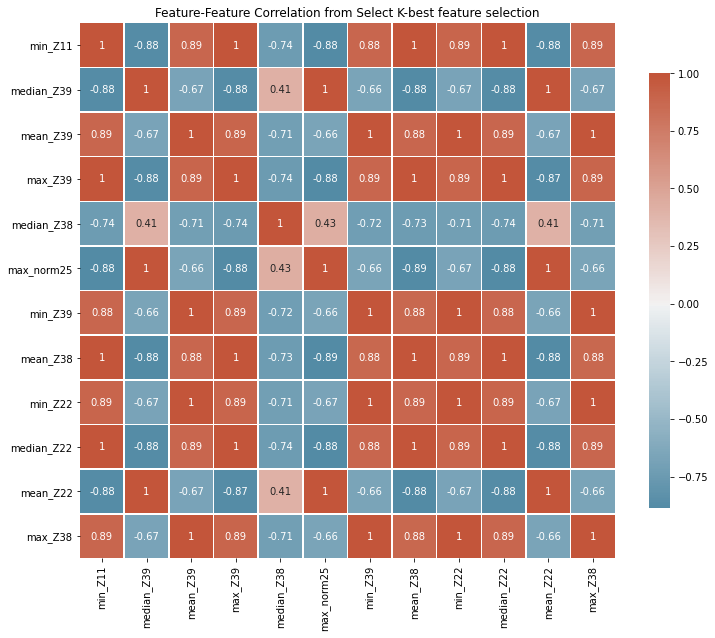

In [ ]:
#@title Select K-best Correlation Matrix

corr = pd.DataFrame(data=X_train_skb, columns=X_train.columns[ord_idx]).corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(12,16))
_ = sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5}, annot=True)

_ = plt.title("Feature-Feature Correlation from Select K-best feature selection")

>## PCA

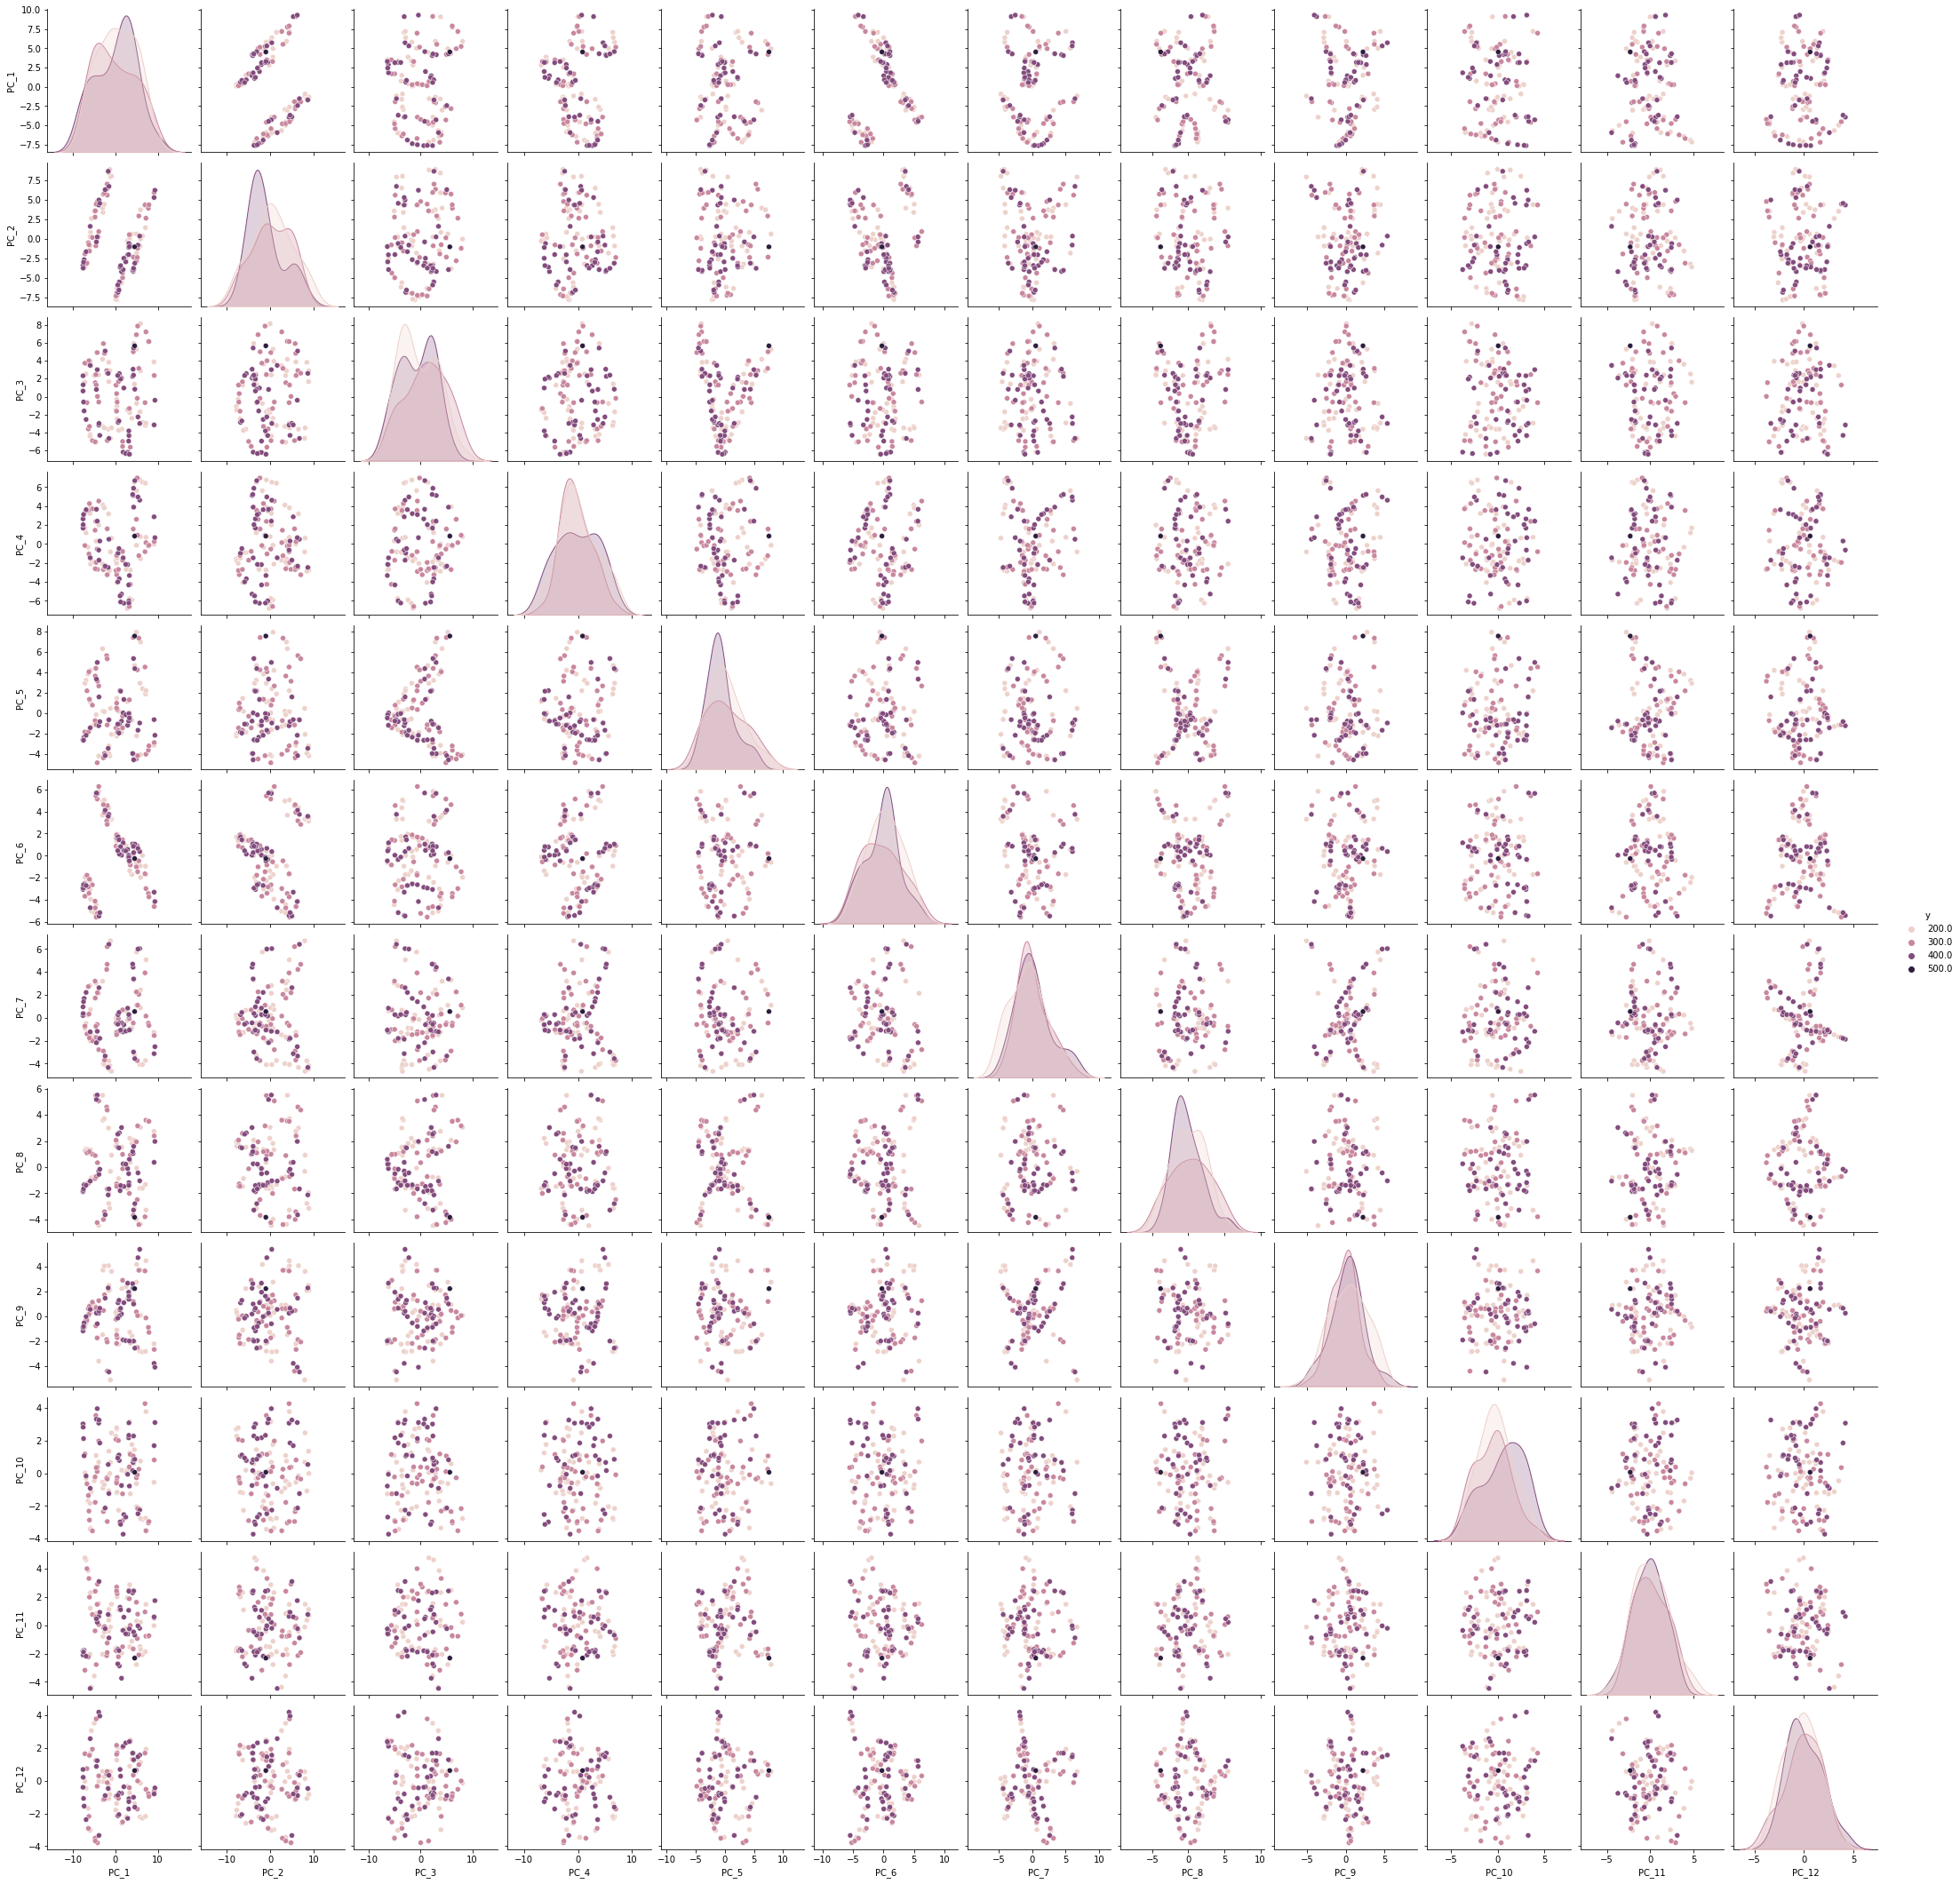

In [ ]:
#@title PCA Pairs Plot
# this takes a few minutes to calculate - avoid if possible
X_pca = pd.DataFrame(data=X_train_pca,columns=[f'PC_{i}'for i in range(1,13)])
X_pca['y'] = y_train
_ = sns.pairplot(X_pca, hue='y')

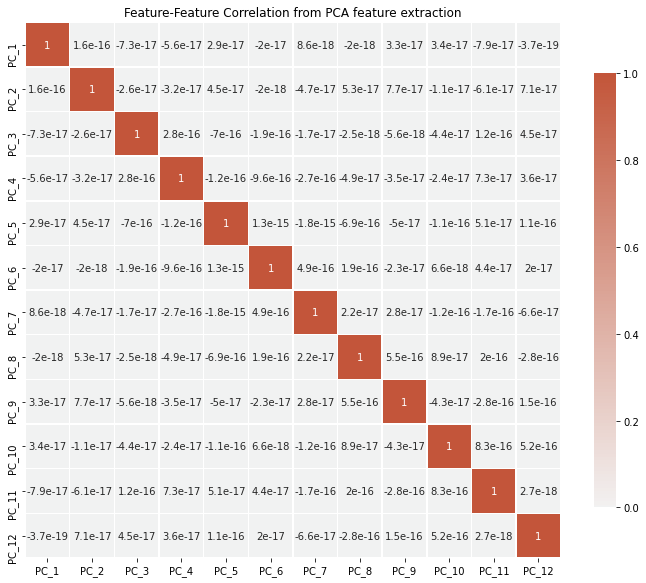

In [ ]:
#@title PCA Correlation Matrix
corr = pd.DataFrame(data=X_train_pca).corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(12,16))
_ = sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, annot=True,
                xticklabels=[f'PC_{i}'for i in range(1,13)],
                yticklabels=[f'PC_{i}'for i in range(1,13)])

_ = plt.title("Feature-Feature Correlation from PCA feature extraction")

---

# Models

We use KNN and Logistic Regression on the different sets of selected features, and compare the different models.


>## K-Nearest Neighbours

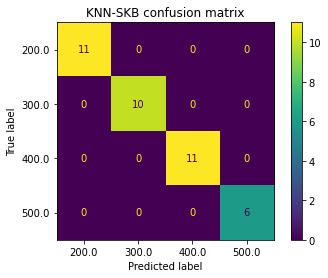

In [ ]:
#@title K-Nearest Neighbours calssification for 12 Best features by SKB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

knn_skb = KNeighborsClassifier(n_neighbors=12)
_ = knn_skb.fit(X_train_skb, y_train)

y_pred_skb = knn_skb.predict(X_test_skb)
y_pred_skb = pd.DataFrame(data=y_pred_skb, index = y_test.index)

p = plot_confusion_matrix(knn_skb, X_test_skb, y_test)
_ = p.ax_.set_title("KNN-SKB confusion matrix")



In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,y_pred_skb))

              precision    recall  f1-score   support

       200.0       1.00      1.00      1.00        11
       300.0       1.00      1.00      1.00        10
       400.0       1.00      1.00      1.00        11
       500.0       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



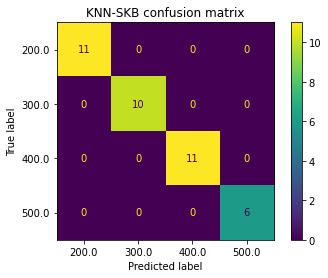

In [ ]:
#@title K-Nearest Neighbours calssification for 12 Best features by PCA

knn_pca = KNeighborsClassifier(n_neighbors=12)
_ = knn_pca.fit(X_train_pca, y_train)

y_pred_pca = knn_pca.predict(X_test_pca)
y_pred_pca = pd.DataFrame(data=y_pred_pca, index = y_test.index)
 
p = plot_confusion_matrix(knn_pca, X_test_pca, y_test)
_ = p.ax_.set_title("KNN-SKB confusion matrix")


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,y_pred_pca))

              precision    recall  f1-score   support

       200.0       1.00      1.00      1.00        11
       300.0       1.00      1.00      1.00        10
       400.0       1.00      1.00      1.00        11
       500.0       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



>## Logistic Regression

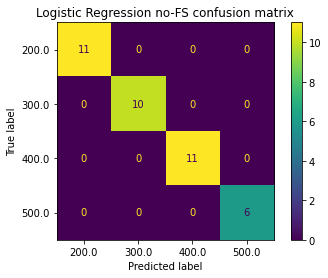

In [ ]:
#@title Logistic Regression calssification for all (2520) features without selection

from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(penalty='l1',solver='saga').fit(X_train,y_train) #this is a Lasso classifier

y_lrc_pred = lrc.predict(X_test)

p = plot_confusion_matrix(lrc,X_test, y_test)
_ = p.ax_.set_title("Logistic Regression no-FS confusion matrix")


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,y_lrc_pred))

              precision    recall  f1-score   support

       200.0       1.00      1.00      1.00        11
       300.0       1.00      1.00      1.00        10
       400.0       1.00      1.00      1.00        11
       500.0       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



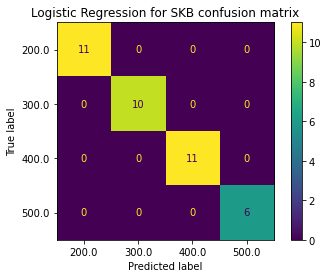

In [ ]:
#@title Logistic Regression calssification for SKB features
lrc_skb = LogisticRegression(penalty='l1',solver='saga').fit(X_train_skb,y_train)

y_lrc_skb_pred = lrc_skb.predict(X_test_skb)

p = plot_confusion_matrix(lrc_skb,X_test_skb, y_test)
_ = p.ax_.set_title("Logistic Regression for SKB confusion matrix")


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,y_lrc_skb_pred))

              precision    recall  f1-score   support

       200.0       1.00      1.00      1.00        11
       300.0       1.00      1.00      1.00        10
       400.0       1.00      1.00      1.00        11
       500.0       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



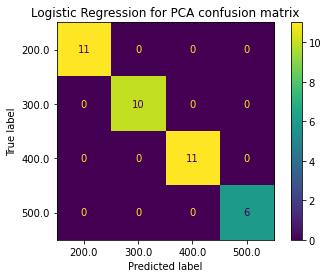

In [ ]:
#@title Logistic Regression calssification for PCA features

lrc_pca = LogisticRegression(penalty='l1',solver='saga').fit(X_train_pca,y_train)

y_lrc_pca_pred = lrc_pca.predict(X_test_pca)

p = plot_confusion_matrix(lrc_pca,X_test_pca, y_test)
_ = p.ax_.set_title("Logistic Regression for PCA confusion matrix")


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,y_lrc_pca_pred))

              precision    recall  f1-score   support

       200.0       1.00      1.00      1.00        11
       300.0       1.00      1.00      1.00        10
       400.0       1.00      1.00      1.00        11
       500.0       1.00      1.00      1.00         6

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



---

We have tried [12,10,8,5,3,2] as the number of features/PC's for both algorithms, and found that the SKB based feature selection is more robust than the PCA based methods

This means that the lower the number of features/PC's, the SKB based methods tend to stay at a high True prediction count and a low-to-0 False prediction count.

